In [1]:
import torch
from torchvision import datasets
import numpy as np
import random
import matplotlib.pyplot as plt
from math import exp

In [2]:
data = datasets.MNIST(root = './' , download=True , train=True)

In [30]:
X = data.data.to(torch.int64).numpy()
Y = data.targets.to(torch.int64).numpy()

In [31]:
X = X[np.logical_or(Y == 3 , Y == 8)]
Y = Y[np.logical_or(Y == 3 , Y == 8)]
x_train = X[0 : 600 , : , :] 
y_train = Y[0 : 600]
x_validation = X[600 : 800 , :]
y_validation = Y[600 : 800]
x_test = X[800 : 1000 , :]
y_test = Y[800 : 1000]
X.shape , Y.shape , x_train.shape ,y_train.shape
x_train = x_train.reshape(600 , 28 * 28)
x_validation = x_validation.reshape(200 , 28 * 28)
x_test = x_test.reshape(200 , 28 * 28)
img = x_train[0].reshape(28 , 28)
c = 10
ids = np.where(y_train == 8)
y_train[ids] = 1
ids = np.where(y_train == 3)
y_train[ids] = -1
ids = np.where(y_validation == 8)
y_validation[ids] = 1
ids = np.where(y_validation == 3)
y_validation[ids] = -1
ids = np.where(y_test== 8)
y_test[ids] = 1
ids = np.where(y_test == 3)
y_test[ids] = -1

(<matplotlib.axes._subplots.AxesSubplot at 0x7fb441653ac8>,
 <matplotlib.image.AxesImage at 0x7fb445865a58>)

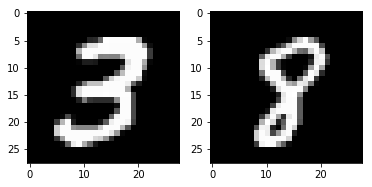

In [32]:
plt.subplot(121) , plt.imshow(img , 'gray')
plt.subplot(122) , plt.imshow(X[16] , 'gray')

In [33]:
def selectRandom(l , h , i):
    while(True):
        j = random.randint(l , h)
        if i != j:
            return j

In [34]:
def dataPoints(i , j):
    return x_train[i , : ] , y_train[i] , x_train[j , :] , y_train[j]

In [35]:
def kernelfunc(x , y):
    return np.dot(x , y.T)

In [36]:
def RBFkernel(x , y):
    gamma = 1 / (28 * 28)
    return np.exp(-gamma * (x - y)**2)

In [37]:
def alphaBounds(a1 , a2 , y1 ,y2 , c):
    if y1 != y2:
        return max(-a1 + a2 , 0) , min(c , c - a1 + a2)
    else:
        return max(a1 + a2 - c , 0) , min(c , a1 + a2)

In [38]:
def calculate_w(alpha , x_train , y_train):
    return np.dot(x_train.T , np.multiply(alpha , y_train))

In [39]:
def calculate_b(w , x_train , y_train):
    b = y_train - np.dot(w.T , x_train.T)
    return np.mean(b)

In [40]:
def calculateError(x , y , w , b):
    t = np.sign((np.dot(w.T , x.T) + b)).astype(int)
    return t - y

In [41]:
tparr,fparr=[],[]
def fit():
    alpha = np.zeros(x_train.shape[0])
    epochs = 0
    while(True): #run until convergence
        for i in range(0 , x_train.shape[0]):
            j = selectRandom(0 , x_train.shape[0] - 1 , i) # selecting j randomly
            xi , yi , xj , yj = dataPoints(i , j)
            kij =  2 * kernelfunc(xi, xj) - kernelfunc(xi , xi) - kernelfunc(xj , xj)
            if kij == 0:
                continue
            alpha_i , alpha_j = alpha[i] , alpha[j]
            L , H = alphaBounds(alpha_i , alpha_j , yi , yj , c)
            w = calculate_w(alpha , x_train , y_train)
            b = calculate_b(w , x_train , y_train)
            Ei = calculateError(xi , yi , w , b)
            Ej = calculateError(xj , yj , w , b)
            alpha[j] = alpha_j - float((yj * (Ei - Ej)) / kij)
            alpha[j] = max(L  , alpha[j])
            alpha[j] = min(H , alpha[j])
            alpha[i] = alpha_i + yi * yj * (alpha_j - alpha[j])
            b1 = b - Ei - yi*kernelfunc(xi , xi)*(alpha[i] - alpha_i) - yj*kernelfunc(xi , xj)*(alpha[j] - alpha_j)
            b2 = b - Ej - yi*kernelfunc(xi , xj)*(alpha[i] - alpha_i) - yj*kernelfunc(xj , xj)*(alpha[j] - alpha_j)
            if b1 > 0 and b1 < c:
                b = b1
            elif b2 > 0 and b2 < c:
                b = b2
            else:
                b = (b1 + b2) / 2
        epochs += 1
        count = 0
        ypred = np.sign(np.dot(w.T , x_test.T) + b) 
        tp=y_validation[np.logical_and(y_validation==1,ypred==1)].shape[0]
        fp=y_validation[np.logical_and(y_validation==-1,ypred==1)].shape[0]
        fn = y_validation[np.logical_and(y_validation==1,ypred== -1)].shape[0]
        tn = y_validation[np.logical_and(y_validation==-1,ypred== -1)].shape[0]
#         tp = tp / (tp + fn)
#         fp = fp / (fp + tn)
        tparr.append(tp)
        fparr.append(fp)
        
        if epochs == 10:
            break
    w = calculate_w(alpha , x_train , y_train)
    b = calculate_b(w , x_train , y_train)
    supportIndex = np.where(alpha != 0)[0]
    supports = x_train[supportIndex , :]
    return w , b , supports , tp , fp

In [42]:
carr = [0.01 , 0.1 , 1 , 10 , 100 , 1000 , 10000 , 100000] 
warr = []
barr = []
farr = []
tarr = []
for i in range(8):
    c = carr[i]
    w , b , s , tp , fp = fit()
    warr.append(w)
    barr.append(b)
    farr.append(fp)
    tarr.append(tp)

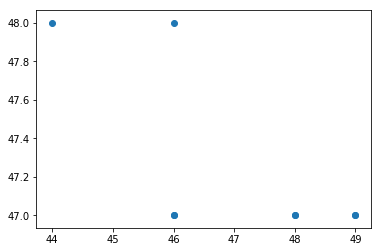

In [46]:
ids = np.argsort(farr)
farr = np.asarray(farr)
tarr = np.asarray(tarr)
farr = farr[ids]
tarr = tarr[ids]
plt.scatter(farr,tarr)
w = warr[ids[0]]
b = barr[ids[0]]

In [44]:
ypred = np.sign(np.dot(w.T , x_test.T) + b)    

In [45]:
count = 0
for i in range(200):
    if ypred[i] == y_test[i]:
        count += 1
print((count / 200) * 100)

91.5
